In [1]:
#!/usr/bin/env python3
"""
Model Training Notebook for Steel Industry Load Type Prediction
This notebook properly handles the Load_Type column issue and trains multiple ML models.
"""

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Additional ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Model Training Phase Started")
print(f"Timestamp: {datetime.now()}")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")

Model Training Phase Started
Timestamp: 2025-10-19 16:06:56.824916
XGBoost available: True
LightGBM available: True


In [2]:
# === LOADING AND PREPARING DATA ===

print("=== LOADING AND PREPARING DATA ===")

# Load the transformed data
try:
    df = pd.read_csv('transformed_data.csv')
    print(f"✓ Data loaded successfully: {df.shape}")
except FileNotFoundError:
    print("❌ Error: transformed_data.csv not found. Please run 03_data_transformation.ipynb first.")
    raise

# Load additional artifacts
try:
    encoders = joblib.load('encoders.pkl')
    transformation_metadata = joblib.load('transformation_metadata.pkl')
    print("✓ Additional artifacts loaded successfully")
    print(f"Target classes: {transformation_metadata['target_classes']}")
except Exception as e:
    print(f"⚠️ Warning: Could not load additional artifacts: {e}")
    transformation_metadata = {}

# Quick overview of loaded data
print("\n=== LOADED DATA OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nTarget distribution:")
target_distribution = df['target'].value_counts().sort_index()
print(target_distribution)

=== LOADING AND PREPARING DATA ===
✓ Data loaded successfully: (35040, 38)
✓ Additional artifacts loaded successfully
Target classes: {'Light_Load': np.int64(0), 'Maximum_Load': np.int64(1), 'Medium_Load': np.int64(2)}

=== LOADED DATA OVERVIEW ===
Shape: (35040, 38)
Columns: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'Load_Type', 'year', 'month', 'day', 'hour', 'minute', 'day_of_year', 'week_of_year', 'quarter', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'Total_Reactive_Power', 'Power_Factor_Difference', 'Power_Efficiency', 'Usage_kWh_lag1', 'Usage_kWh_lag2', 'Usage_kWh_rolling_mean_3', 'Usage_kWh_rolling_std_3', 'WeekStatus_encoded', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Usage_Intensity_Low', 'Usage_Intensity_Medium', 'Usage_Intensity_High', '

In [3]:
# === FIXING FEATURE SELECTION ===

print("\n=== FIXING FEATURE SELECTION ===")

# Get all numeric and boolean columns
numeric_columns = df.select_dtypes(include=[np.number, bool]).columns.tolist()
print(f"Numeric and boolean columns available: {len(numeric_columns)}")
print(f"Numeric columns: {numeric_columns}")

# Exclude target and Load_Type columns
features_to_exclude = ['target', 'Load_Type']
feature_columns = [col for col in numeric_columns if col not in features_to_exclude]

print(f"\nFeatures to exclude: {features_to_exclude}")
print(f"Features to use: {len(feature_columns)}")
print(f"Feature columns: {feature_columns}")

# Verify no string columns in features
features_df = df[feature_columns]
string_columns = features_df.select_dtypes(include=['object']).columns
if len(string_columns) > 0:
    print(f"❌ ERROR: String columns still present: {list(string_columns)}")
else:
    print("✅ All features are numeric/boolean")

# Separate features and target
X = df[feature_columns].copy()
y = df['target'].copy()

print(f"\nFinal feature set: {X.shape}")
print(f"Target set: {y.shape}")
print(f"Target classes: {sorted(y.unique())}")

# Check data quality
print(f"\nData quality check:")
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")
print(f"Feature data types:\n{X.dtypes.value_counts()}")


=== FIXING FEATURE SELECTION ===
Numeric and boolean columns available: 37
Numeric columns: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'year', 'month', 'day', 'hour', 'minute', 'day_of_year', 'week_of_year', 'quarter', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'Total_Reactive_Power', 'Power_Factor_Difference', 'Power_Efficiency', 'Usage_kWh_lag1', 'Usage_kWh_lag2', 'Usage_kWh_rolling_mean_3', 'Usage_kWh_rolling_std_3', 'WeekStatus_encoded', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Usage_Intensity_Low', 'Usage_Intensity_Medium', 'Usage_Intensity_High', 'target']

Features to exclude: ['target', 'Load_Type']
Features to use: 36
Feature columns: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)'

In [4]:
# === DATA SPLITTING ===

print("\n=== DATA SPLITTING ===")

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train_split.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {X_train_split.shape[1]}")

# Check class balance in splits
print(f"\nClass distribution in training set:")
train_dist = y_train_split.value_counts().sort_index()
for class_val, count in train_dist.items():
    print(f"  Class {class_val}: {count:,} samples ({count/len(y_train_split)*100:.1f}%)")

print(f"\nClass distribution in validation set:")
val_dist = y_val.value_counts().sort_index()
for class_val, count in val_dist.items():
    print(f"  Class {class_val}: {count:,} samples ({count/len(y_val)*100:.1f}%)")

print(f"\nClass distribution in testing set:")
test_dist = y_test.value_counts().sort_index()
for class_val, count in test_dist.items():
    print(f"  Class {class_val}: {count:,} samples ({count/len(y_test)*100:.1f}%)")


=== DATA SPLITTING ===
Training set: 22,425 samples
Validation set: 5,607 samples
Test set: 7,008 samples
Features: 36

Class distribution in training set:
  Class 0: 11,565 samples (51.6%)
  Class 1: 4,654 samples (20.8%)
  Class 2: 6,206 samples (27.7%)

Class distribution in validation set:
  Class 0: 2,892 samples (51.6%)
  Class 1: 1,164 samples (20.8%)
  Class 2: 1,551 samples (27.7%)

Class distribution in testing set:
  Class 0: 3,615 samples (51.6%)
  Class 1: 1,454 samples (20.7%)
  Class 2: 1,939 samples (27.7%)


In [5]:
# === MODEL DEFINITION ===

print("=== MODEL DEFINITION ===")

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(random_state=42, max_iter=500),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Add XGBoost and LightGBM if available
if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
    print("✓ XGBoost added to model list")

if LIGHTGBM_AVAILABLE:
    models['LightGBM'] = lgb.LGBMClassifier(random_state=42, verbose=-1)
    print("✓ LightGBM added to model list")

print(f"\nTotal models to train: {len(models)}")
print(f"Models: {list(models.keys())}")

# Initialize results storage
model_results = []
trained_models = {}

=== MODEL DEFINITION ===
✓ XGBoost added to model list
✓ LightGBM added to model list

Total models to train: 12
Models: ['Random Forest', 'Gradient Boosting', 'Extra Trees', 'Logistic Regression', 'Decision Tree', 'SVM', 'K-Nearest Neighbors', 'Naive Bayes', 'Neural Network', 'AdaBoost', 'XGBoost', 'LightGBM']


In [6]:
# === TRAINING MODELS ===

print("\n=== TRAINING MODELS WITH DEFAULT PARAMETERS ===")

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = datetime.now()

    try:
        # Train the model
        model.fit(X_train_split, y_train_split)

        # Make predictions on validation set
        y_val_pred = model.predict(X_val)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, average='weighted')
        recall = recall_score(y_val, y_val_pred, average='weighted')
        f1 = f1_score(y_val, y_val_pred, average='weighted')

        # Cross-validation score
        cv_scores = cross_val_score(model, X_train_split, y_train_split, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        training_time = (datetime.now() - start_time).total_seconds()

        # Store results
        result = {
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'CV_Mean': cv_mean,
            'CV_Std': cv_std,
            'Training_Time': training_time
        }

        model_results.append(result)
        trained_models[name] = model

        print(f"  ✓ Accuracy: {accuracy:.4f}")
        print(f"  ✓ F1-Score: {f1:.4f}")
        print(f"  ✓ CV Score: {cv_mean:.4f} (±{cv_std:.4f})")
        print(f"  ✓ Training time: {training_time:.2f}s")

    except Exception as e:
        print(f"  ❌ Error training {name}: {e}")
        continue

print(f"\n✅ Successfully trained {len(trained_models)} models")


=== TRAINING MODELS WITH DEFAULT PARAMETERS ===

Training Random Forest...
  ✓ Accuracy: 0.9929
  ✓ F1-Score: 0.9929
  ✓ CV Score: 0.9913 (±0.0011)
  ✓ Training time: 2.13s

Training Gradient Boosting...
  ✓ Accuracy: 0.9888
  ✓ F1-Score: 0.9888
  ✓ CV Score: 0.9859 (±0.0021)
  ✓ Training time: 108.22s

Training Extra Trees...
  ✓ Accuracy: 0.9897
  ✓ F1-Score: 0.9896
  ✓ CV Score: 0.9874 (±0.0019)
  ✓ Training time: 1.19s

Training Logistic Regression...
  ✓ Accuracy: 0.8334
  ✓ F1-Score: 0.8327
  ✓ CV Score: 0.8297 (±0.0032)
  ✓ Training time: 4.30s

Training Decision Tree...
  ✓ Accuracy: 0.9907
  ✓ F1-Score: 0.9907
  ✓ CV Score: 0.9895 (±0.0012)
  ✓ Training time: 0.82s

Training SVM...
  ✓ Accuracy: 0.9121
  ✓ F1-Score: 0.9113
  ✓ CV Score: 0.9045 (±0.0056)
  ✓ Training time: 102.50s

Training K-Nearest Neighbors...
  ✓ Accuracy: 0.8901
  ✓ F1-Score: 0.8898
  ✓ CV Score: 0.8858 (±0.0031)
  ✓ Training time: 0.39s

Training Naive Bayes...
  ✓ Accuracy: 0.7421
  ✓ F1-Score: 0.7201
 

=== MODEL COMPARISON AND SELECTION ===

Model Performance Comparison (sorted by Accuracy):


,Model,Accuracy,Precision,Recall,F1_Score,CV_Mean,CV_Std,Training_Time
11,LightGBM,0.9996,0.9996,0.9996,0.9996,0.9991,0.0003,1.6418
10,XGBoost,0.9996,0.9996,0.9996,0.9996,0.9985,0.0003,2.8626
0,Random Forest,0.9929,0.9929,0.9929,0.9929,0.9913,0.0011,2.1262
4,Decision Tree,0.9907,0.9907,0.9907,0.9907,0.9895,0.0012,0.8179
2,Extra Trees,0.9897,0.9896,0.9897,0.9896,0.9874,0.0019,1.1897
1,Gradient Boosting,0.9888,0.9888,0.9888,0.9888,0.9859,0.0021,108.2230
8,Neural Network,0.9838,0.9838,0.9838,0.9838,0.9819,0.0018,80.5114
5,SVM,0.9121,0.9123,0.9121,0.9113,0.9045,0.0056,102.4967
6,K-Nearest Neighbors,0.8901,0.8899,0.8901,0.8898,0.8858,0.0031,0.3926
3,Logistic Regression,0.8334,0.8320,0.8334,0.8327,0.8297,0.0032,4.2958


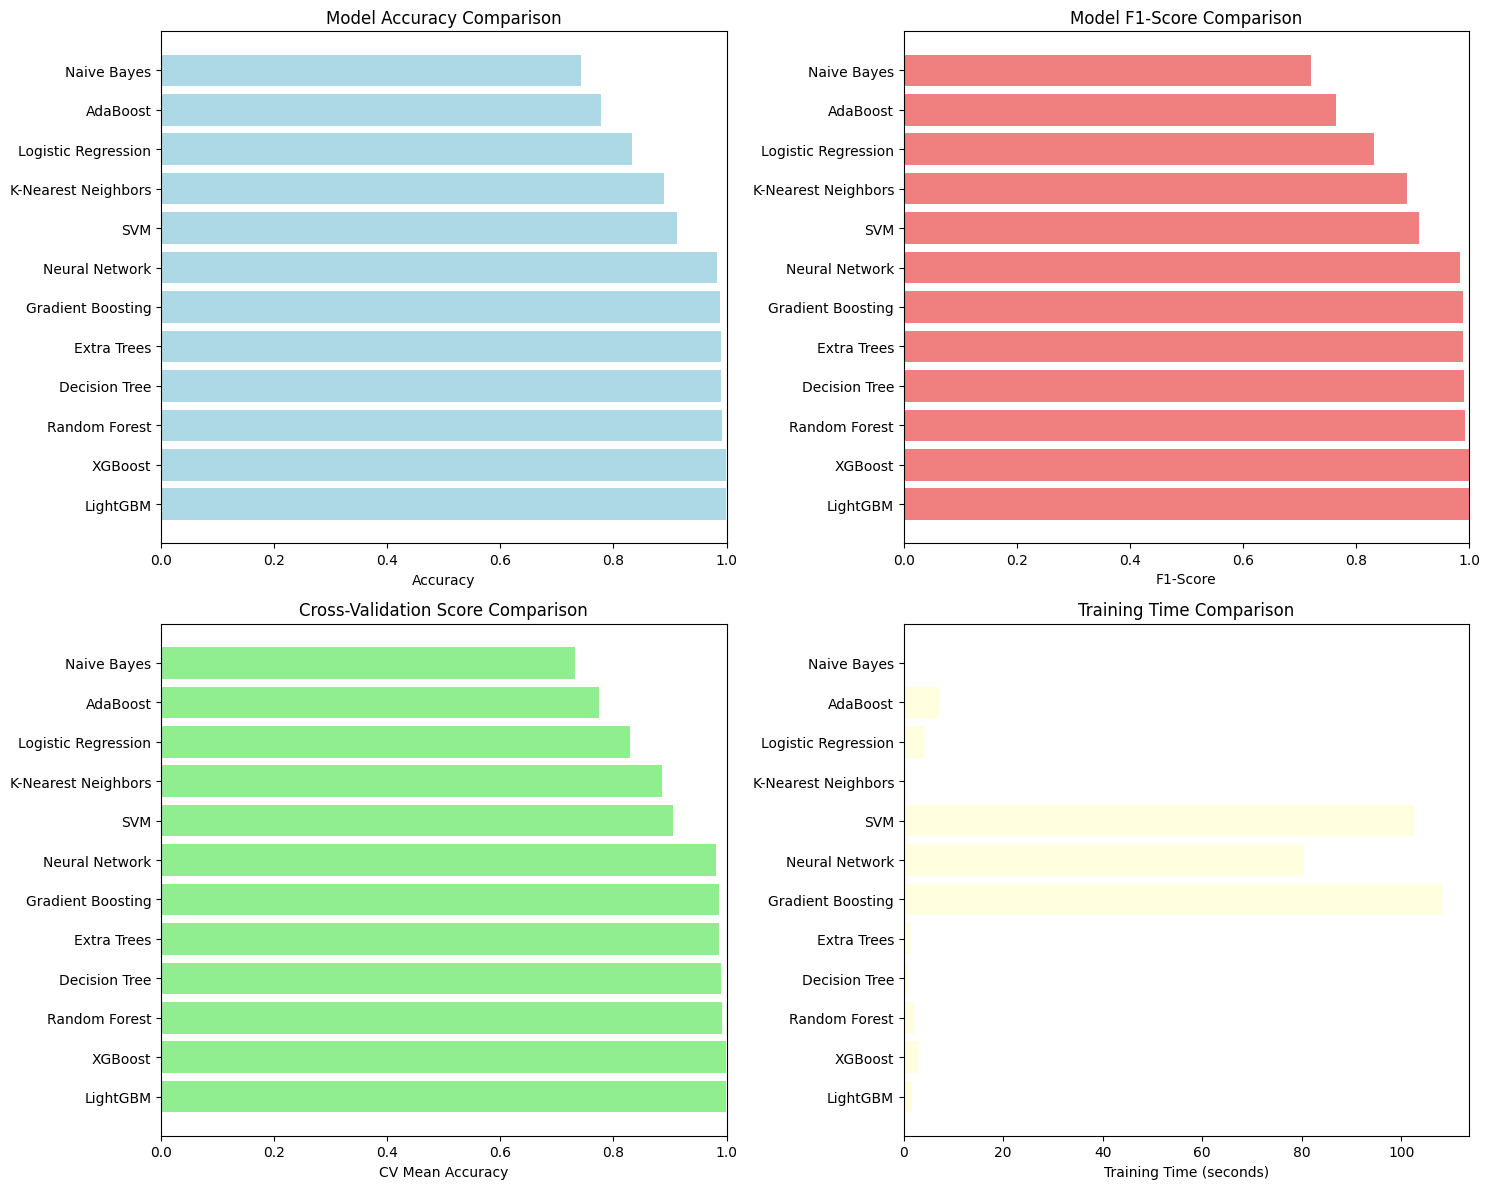


🏆 Top 3 performing models:
1. LightGBM:
   • Accuracy: 0.9996
   • F1-Score: 0.9996
   • CV Score: 0.9991 (±0.0003)
2. XGBoost:
   • Accuracy: 0.9996
   • F1-Score: 0.9996
   • CV Score: 0.9985 (±0.0003)
3. Random Forest:
   • Accuracy: 0.9929
   • F1-Score: 0.9929
   • CV Score: 0.9913 (±0.0011)

🥇 Best performing model: LightGBM


In [7]:
# === MODEL COMPARISON ===

print("=== MODEL COMPARISON AND SELECTION ===")

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\nModel Performance Comparison (sorted by Accuracy):")
display(results_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='lightblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim(0, 1)

# F1-Score comparison
axes[0, 1].barh(results_df['Model'], results_df['F1_Score'], color='lightcoral')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_xlim(0, 1)

# Cross-validation scores
axes[1, 0].barh(results_df['Model'], results_df['CV_Mean'], color='lightgreen')
axes[1, 0].set_xlabel('CV Mean Accuracy')
axes[1, 0].set_title('Cross-Validation Score Comparison')
axes[1, 0].set_xlim(0, 1)

# Training time
axes[1, 1].barh(results_df['Model'], results_df['Training_Time'], color='lightyellow')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison')

plt.tight_layout()
plt.show()

# Select top performing models
top_n = min(3, len(results_df))
top_models = results_df.head(top_n)['Model'].tolist()

print(f"\n🏆 Top {top_n} performing models:")
for i, model_name in enumerate(top_models, 1):
    model_row = results_df[results_df['Model'] == model_name].iloc[0]
    print(f"{i}. {model_name}:")
    print(f"   • Accuracy: {model_row['Accuracy']:.4f}")
    print(f"   • F1-Score: {model_row['F1_Score']:.4f}")
    print(f"   • CV Score: {model_row['CV_Mean']:.4f} (±{model_row['CV_Std']:.4f})")

best_model_name = top_models[0]
best_model = trained_models[best_model_name]
print(f"\n🥇 Best performing model: {best_model_name}")

In [8]:
# === EVALUATING BEST MODEL ===

print(f"\n=== EVALUATING BEST MODEL: {best_model_name} ===")

# Get the best model and retrain on full training data
best_model = trained_models[best_model_name]
best_model.fit(X_train, y_train)

# Make predictions on test set
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)

# Calculate final metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"🎯 FINAL MODEL PERFORMANCE ON TEST SET:")
print(f"Model: {best_model_name}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Get class names
class_names = ['Light_Load', 'Maximum_Load', 'Medium_Load']  # Default
try:
    target_classes = transformation_metadata['target_classes']
    class_names = [k for k, v in sorted(target_classes.items(), key=lambda x: x[1])]
    print(f"Class names: {class_names}")
except:
    pass

# Detailed classification report
print(f"\n📊 DETAILED CLASSIFICATION REPORT:")
report = classification_report(y_test, y_test_pred, target_names=class_names)
print(report)


=== EVALUATING BEST MODEL: LightGBM ===
🎯 FINAL MODEL PERFORMANCE ON TEST SET:
Model: LightGBM
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F1-Score: 0.9997
Class names: ['Light_Load', 'Maximum_Load', 'Medium_Load']

📊 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Light_Load       1.00      1.00      1.00      3615
Maximum_Load       1.00      1.00      1.00      1454
 Medium_Load       1.00      1.00      1.00      1939

    accuracy                           1.00      7008
   macro avg       1.00      1.00      1.00      7008
weighted avg       1.00      1.00      1.00      7008




=== CONFUSION MATRIX ===


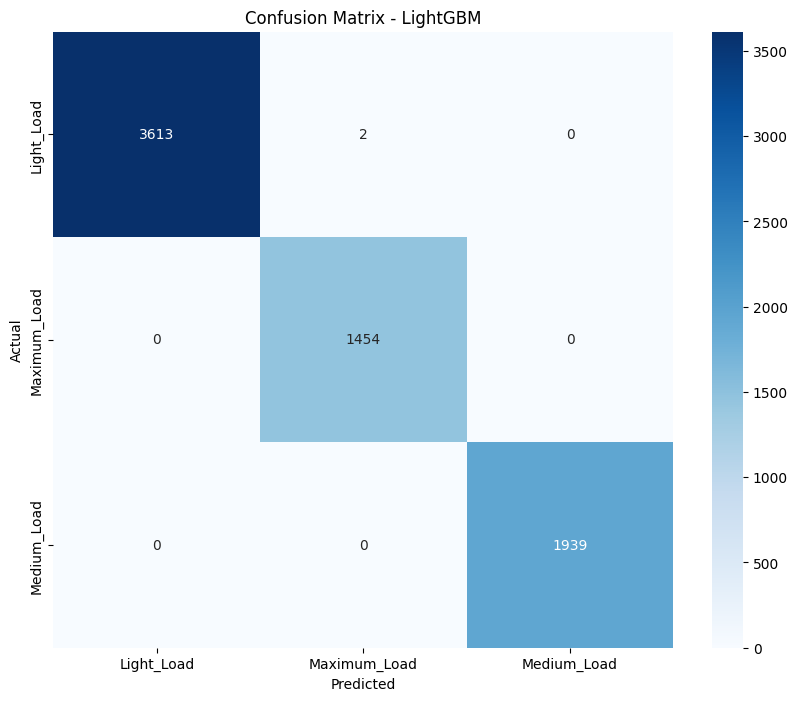


Per-class performance:

Light_Load (Class 0):
  Precision: 1.0000
  Recall: 0.9994
  F1-Score: 0.9997
  Support: 3615

Maximum_Load (Class 1):
  Precision: 0.9986
  Recall: 1.0000
  F1-Score: 0.9993
  Support: 1454

Medium_Load (Class 2):
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  Support: 1939


In [9]:
# === CONFUSION MATRIX ===

print("\n=== CONFUSION MATRIX ===")

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate per-class metrics
print("\nPer-class performance:")
for i, class_name in enumerate(class_names):
    class_mask = (y_test == i)
    class_predictions = (y_test_pred == i)

    tp = np.sum(class_mask & class_predictions)
    fp = np.sum(~class_mask & class_predictions)
    fn = np.sum(class_mask & ~class_predictions)
    tn = np.sum(~class_mask & ~class_predictions)

    class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0

    print(f"\n{class_name} (Class {i}):")
    print(f"  Precision: {class_precision:.4f}")
    print(f"  Recall: {class_recall:.4f}")
    print(f"  F1-Score: {class_f1:.4f}")
    print(f"  Support: {np.sum(class_mask)}")

=== FEATURE IMPORTANCE ANALYSIS ===

Top 15 most important features for LightGBM:


,Feature,Importance
6,NSM,2184
9,day,1254
12,day_of_year,1228
18,month_cos,641
24,Usage_kWh_rolling_mean_3,481
23,Usage_kWh_lag2,446
0,Usage_kWh,402
17,month_sin,387
8,month,330
21,Power_Efficiency,190


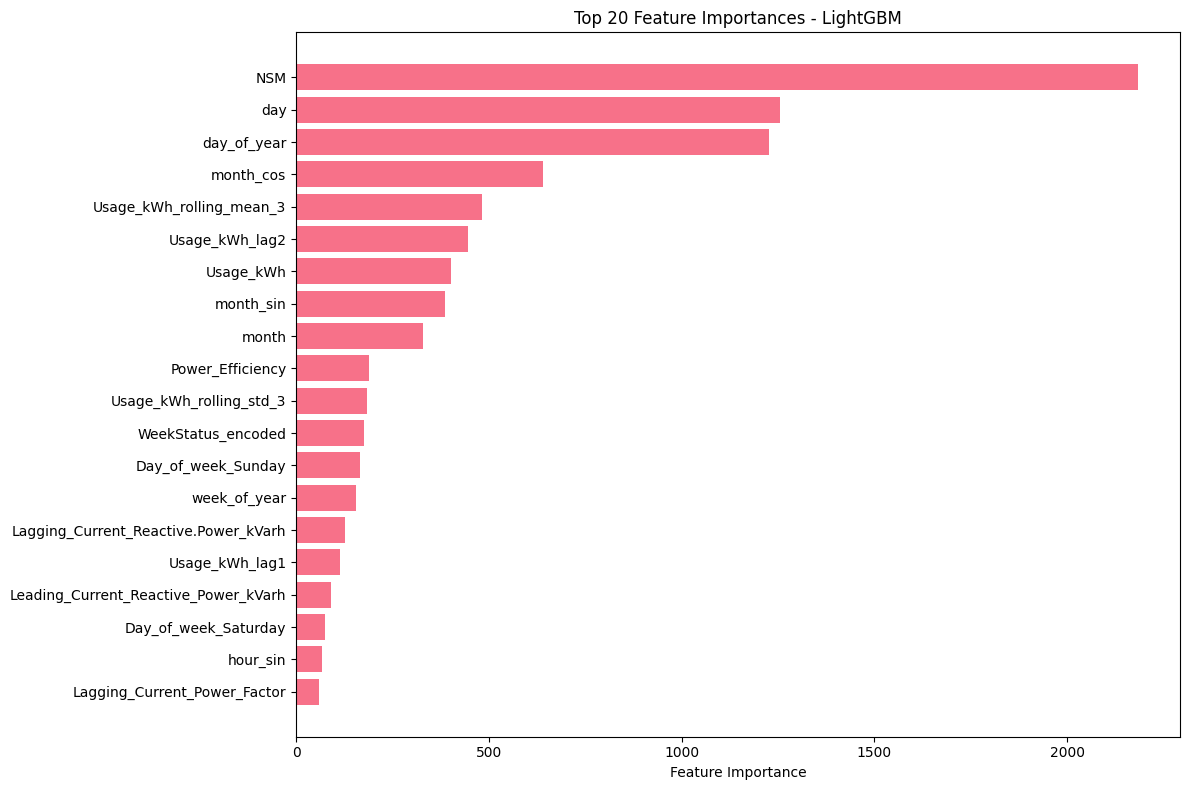


✓ Feature importance saved to feature_importance.csv


In [10]:
# === FEATURE IMPORTANCE ANALYSIS ===

print("=== FEATURE IMPORTANCE ANALYSIS ===")

if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    feature_importance = best_model.feature_importances_

    # Create DataFrame for better handling
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print(f"\nTop 15 most important features for {best_model_name}:")
    display(feature_importance_df.head(15))

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)

    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Save feature importance
    feature_importance_df.to_csv('feature_importance.csv', index=False)
    print("\n✓ Feature importance saved to feature_importance.csv")

elif hasattr(best_model, 'coef_'):
    # For linear models
    feature_coefficients = np.abs(best_model.coef_).mean(axis=0)

    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient_Magnitude': feature_coefficients
    }).sort_values('Coefficient_Magnitude', ascending=False)

    print(f"\nTop 15 features by coefficient magnitude for {best_model_name}:")
    display(feature_importance_df.head(15))

else:
    print(f"\n⚠️ {best_model_name} does not provide feature importance information")
    feature_importance_df = None

In [11]:
# === MODEL PREDICTION EXAMPLES ===

print("=== MODEL PREDICTION EXAMPLES ===")

# Select a few test samples for demonstration
sample_indices = np.random.choice(X_test.index, size=min(10, len(X_test)), replace=False)
sample_X = X_test.loc[sample_indices]
sample_y_true = y_test.loc[sample_indices]
sample_y_pred = best_model.predict(sample_X)
sample_y_pred_proba = best_model.predict_proba(sample_X)

print(f"\nPrediction examples from test set:")
print("="*80)

for i, idx in enumerate(sample_indices):
    true_class = sample_y_true.loc[idx]
    pred_class = sample_y_pred[i]
    probabilities = sample_y_pred_proba[i]

    true_class_name = class_names[true_class] if true_class < len(class_names) else f"Class_{true_class}"
    pred_class_name = class_names[pred_class] if pred_class < len(class_names) else f"Class_{pred_class}"

    print(f"\nSample {i+1} (Index: {idx}):")
    print(f"  True Class: {true_class_name}")
    print(f"  Predicted Class: {pred_class_name}")
    print(f"  Prediction Confidence: {probabilities[pred_class]:.4f}")
    print(f"  All Probabilities: {[f'{class_names[j]}: {prob:.4f}' for j, prob in enumerate(probabilities)]}")

    if true_class == pred_class:
        print(f"  ✅ Correct Prediction")
    else:
        print(f"  ❌ Incorrect Prediction")

print("="*80)

# Summary statistics
correct_predictions = np.sum(sample_y_true == sample_y_pred)
print(f"\nSample accuracy: {correct_predictions}/{len(sample_indices)} ({correct_predictions/len(sample_indices)*100:.1f}%)")

=== MODEL PREDICTION EXAMPLES ===

Prediction examples from test set:

Sample 1 (Index: 23348):
  True Class: Light_Load
  Predicted Class: Light_Load
  Prediction Confidence: 1.0000
  All Probabilities: ['Light_Load: 1.0000', 'Maximum_Load: 0.0000', 'Medium_Load: 0.0000']
  ✅ Correct Prediction

Sample 2 (Index: 3395):
  True Class: Light_Load
  Predicted Class: Light_Load
  Prediction Confidence: 1.0000
  All Probabilities: ['Light_Load: 1.0000', 'Maximum_Load: 0.0000', 'Medium_Load: 0.0000']
  ✅ Correct Prediction

Sample 3 (Index: 18943):
  True Class: Light_Load
  Predicted Class: Light_Load
  Prediction Confidence: 1.0000
  All Probabilities: ['Light_Load: 1.0000', 'Maximum_Load: 0.0000', 'Medium_Load: 0.0000']
  ✅ Correct Prediction

Sample 4 (Index: 32898):
  True Class: Light_Load
  Predicted Class: Light_Load
  Prediction Confidence: 0.9996
  All Probabilities: ['Light_Load: 0.9996', 'Maximum_Load: 0.0000', 'Medium_Load: 0.0003']
  ✅ Correct Prediction

Sample 5 (Index: 33147

In [12]:
# === SAVING FINAL MODEL AND RESULTS ===

print("=== SAVING FINAL MODEL AND RESULTS ===")

try:
    # Save the final model
    model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(best_model, model_filename)
    print(f"✓ Final model saved as: {model_filename}")

    # Save model metadata
    model_metadata = {
        'model_name': best_model_name,
        'model_type': type(best_model).__name__,
        'training_date': datetime.now().isoformat(),
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1_score': test_f1,
        'feature_count': len(feature_columns),
        'feature_names': feature_columns,
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'class_names': class_names,
        'target_classes': transformation_metadata.get('target_classes', {}),
        'model_parameters': best_model.get_params() if hasattr(best_model, 'get_params') else {}
    }

    joblib.dump(model_metadata, 'model_metadata.pkl')
    print("✓ Model metadata saved as: model_metadata.pkl")

    # Save comprehensive results
    comprehensive_results = {
        'all_model_results': results_df.to_dict(),
        'final_model_performance': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1
        },
        'confusion_matrix': cm.tolist(),
        'classification_report': classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True),
        'feature_importance': feature_importance_df.to_dict() if feature_importance_df is not None else None
    }

    joblib.dump(comprehensive_results, 'comprehensive_results.pkl')
    print("✓ Comprehensive results saved as: comprehensive_results.pkl")

    # Save predictions for analysis
    predictions_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred': y_test_pred,
        'correct': (y_test == y_test_pred)
    })

    # Add probability columns
    for i, class_name in enumerate(class_names):
        predictions_df[f'prob_{class_name}'] = y_test_pred_proba[:, i]

    predictions_df.to_csv('test_predictions.csv', index=False)
    print("✓ Test predictions saved as: test_predictions.csv")

except Exception as e:
    print(f"❌ Error saving model and results: {e}")

print("\n📁 Saved files:")
saved_files = [
    model_filename,
    'model_metadata.pkl',
    'comprehensive_results.pkl',
    'test_predictions.csv'
]

if feature_importance_df is not None:
    saved_files.append('feature_importance.csv')

for file in saved_files:
    print(f"  • {file}")

=== SAVING FINAL MODEL AND RESULTS ===
✓ Final model saved as: best_model_lightgbm.pkl
✓ Model metadata saved as: model_metadata.pkl
✓ Comprehensive results saved as: comprehensive_results.pkl
✓ Test predictions saved as: test_predictions.csv

📁 Saved files:
  • best_model_lightgbm.pkl
  • model_metadata.pkl
  • comprehensive_results.pkl
  • test_predictions.csv
  • feature_importance.csv


In [13]:
# === MODEL TRAINING SUMMARY ===

print("="*60)
print("            MODEL TRAINING SUMMARY")
print("="*60)

print(f"📊 Dataset Information:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Features: {len(feature_columns)}")
print(f"   • Classes: {len(class_names)} ({', '.join(class_names)})")
print(f"   • Training samples: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"   • Test samples: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")

print(f"\n🤖 Models Evaluated:")
print(f"   • Total models trained: {len(results_df)}")
print(f"   • Best performing model: {best_model_name}")

print(f"\n📈 Model Performance Ranking:")
for i, (_, row) in enumerate(results_df.head(5).iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['Accuracy']:.4f} accuracy, {row['F1_Score']:.4f} F1")

print(f"\n🎯 Final Model Performance:")
print(f"   • Model: {best_model_name}")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Test Precision: {test_precision:.4f}")
print(f"   • Test Recall: {test_recall:.4f}")
print(f"   • Test F1-Score: {test_f1:.4f}")

print(f"\n📊 Per-Class Performance:")
class_report_dict = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
for class_name in class_names:
    if class_name in class_report_dict:
        metrics = class_report_dict[class_name]
        print(f"   • {class_name}:")
        print(f"     - Precision: {metrics['precision']:.4f}")
        print(f"     - Recall: {metrics['recall']:.4f}")
        print(f"     - F1-Score: {metrics['f1-score']:.4f}")
        print(f"     - Support: {metrics['support']}")

if feature_importance_df is not None:
    print(f"\n🔝 Top 5 Most Important Features:")
    for i, (_, row) in enumerate(feature_importance_df.head(5).iterrows(), 1):
        importance_col = 'Importance' if 'Importance' in row else 'Coefficient_Magnitude'
        print(f"   {i}. {row['Feature']}: {row[importance_col]:.4f}")

print(f"\n💾 Saved Artifacts:")
for file in saved_files:
    print(f"   • {file}")

print(f"\n⏱️ Training Summary:")
total_training_time = sum([r['Training_Time'] for r in model_results])
print(f"   • Total training time: {total_training_time:.2f}s")

print(f"\n🎯 Model Readiness:")
if test_accuracy >= 0.9:
    readiness = "🌟 Excellent - Ready for Production"
elif test_accuracy >= 0.8:
    readiness = "✅ Good - Ready for Deployment"
elif test_accuracy >= 0.7:
    readiness = "⚠️ Acceptable - Consider Further Tuning"
else:
    readiness = "❌ Poor - Needs Significant Improvement"

print(f"   • Status: {readiness}")
print(f"   • Model file: {model_filename}")
print(f"   • Ready for inference: ✅")

print("="*60)
print("Model Training Phase Completed Successfully!")
print(f"Timestamp: {datetime.now()}")
print(f"🏆 Best Model: {best_model_name} with {test_accuracy:.4f} accuracy")
print("="*60)

print("\n🚀 Next Steps:")
print("   1. Load the saved model for inference")
print("   2. Monitor model performance in production")
print("   3. Retrain periodically with new data")
print("   4. Consider ensemble methods for improved performance")

            MODEL TRAINING SUMMARY
📊 Dataset Information:
   • Total samples: 35,040
   • Features: 36
   • Classes: 3 (Light_Load, Maximum_Load, Medium_Load)
   • Training samples: 28,032 (80.0%)
   • Test samples: 7,008 (20.0%)

🤖 Models Evaluated:
   • Total models trained: 12
   • Best performing model: LightGBM

📈 Model Performance Ranking:
   1. LightGBM: 0.9996 accuracy, 0.9996 F1
   2. XGBoost: 0.9996 accuracy, 0.9996 F1
   3. Random Forest: 0.9929 accuracy, 0.9929 F1
   4. Decision Tree: 0.9907 accuracy, 0.9907 F1
   5. Extra Trees: 0.9897 accuracy, 0.9896 F1

🎯 Final Model Performance:
   • Model: LightGBM
   • Test Accuracy: 0.9997 (99.97%)
   • Test Precision: 0.9997
   • Test Recall: 0.9997
   • Test F1-Score: 0.9997

📊 Per-Class Performance:
   • Light_Load:
     - Precision: 1.0000
     - Recall: 0.9994
     - F1-Score: 0.9997
     - Support: 3615.0
   • Maximum_Load:
     - Precision: 0.9986
     - Recall: 1.0000
     - F1-Score: 0.9993
     - Support: 1454.0
   • Mediu